In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm import tqdm_gui
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:21, 2465.87it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [5]:
from collections import Counter
from collections import defaultdict

In [6]:
cities = []
for i in range(len(responses)):
    cities.append(responses[i]['city'])

cities_cnt = Counter(cities)
#cities_cnt.most_common()

In [7]:
banks = []
for i in range(len(responses)):
    banks.append(responses[i]['bank_name'])

banks_cnt = Counter(banks)
#banks_cnt.most_common()

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [8]:
# city process  - lowcase, remove "г. "

In [9]:
##
## 1 Посчитайте количество отзывов в разных городах и на разные банки
##

cities = []
banks = []
for i in range(len(responses)):
    city = str(responses[i]['city'])
    city = city.lower().replace("г. ", "")
    cities.append(city)
    banks.append(responses[i]['bank_name'])
    
cities_cnt = Counter(cities)
banks_cnt = Counter(banks)

print ( cities_cnt.most_common(20),"\n" )
print ( banks_cnt.most_common(20) )

[('москва', 56750), ('none', 15174), ('санкт-петербург', 14651), ('новосибирск', 2379), ('екатеринбург', 2374), ('нижний новгород', 2035), ('ростов-на-дону', 1933), ('самара', 1784), ('челябинск', 1539), ('казань', 1515), ('уфа', 1317), ('краснодар', 1292), ('красноярск', 1264), ('воронеж', 1232), ('пермь', 1197), ('омск', 1057), ('волгоград', 1049), ('саратов', 963), ('иркутск', 770), ('калининград', 766)] 

[('Сбербанк России', 26327), ('Альфа-Банк', 10224), ('ВТБ 24', 8185), ('Русский Стандарт', 7943), ('Хоум Кредит Банк', 7549), ('Тинькофф Банк', 5387), ('Национальный Банк «Траст»', 4607), ('Ренессанс Кредит', 3849), ('Связной Банк', 3775), ('ОТП Банк', 3237), ('Восточный Экспресс Банк', 3138), ('Райффайзенбанк', 3057), ('Московский Кредитный Банк', 2944), ('Ситибанк', 2848), ('Авангард', 2733), ('Промсвязьбанк', 2586), ('ЮниКредит Банк', 2488), ('Банк Москвы', 2456), ('Ханты-Мансийский банк Открытие', 2158), ('МТС Банк', 1870)]


In [10]:
from nltk.tokenize import toktok

100%|██████████| 153499/153499 [00:49<00:00, 3105.00it/s]


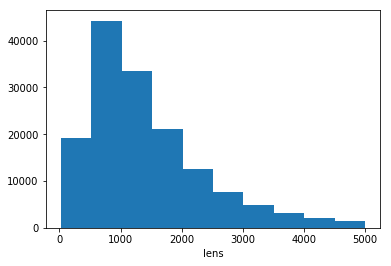

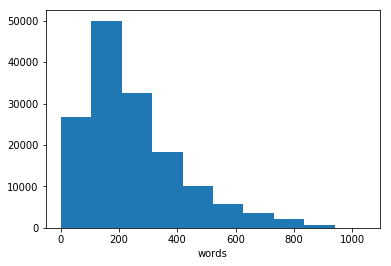

In [11]:
##
## 2 Постройте гистограмы длин слов в символах и в словах
##
from nltk.tokenize import toktok
lens = []
words = []
toktok = toktok.ToktokTokenizer()
#lenresp = 10000
lenresp = len (responses)
for i in tqdm ( range( lenresp ) ) :
    resp = responses[i]['text']
    if len(resp) < 5000:
        lens.append( len(resp) )
        words.append( len( toktok.tokenize(resp) ) )
    
n, bins, patches = plt.hist(lens, histtype = 'bar')
plt.xlabel("lens")
plt.show()

n, bins, patches = plt.hist(words, histtype = 'bar')
plt.xlabel("words")
plt.show()

# lens_cnt = Counter(lens)
# plt.bar( lens_cnt.keys(), lens_cnt.values(),200)
# plt.show

# n, bins, patches = plt.hist(words, histtype = 'bar')
# plt.xlabel("words")
# plt.show()


In [12]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import re

In [13]:
##
## 3 Найдите 10 самых частых слов, слов без стоп слов, лемм, существительных
##
words = []
words_nostop = []
lemms = []
nouns = []
n_types = []
n_tokens = []
cnt = Counter()
resp_good = []
resp_bad = []
resp_bi_good = []
resp_bi_bad = []
resp_all_text = []
# lenresp = 50000
#lenresp = len(responses)
pm2 = MorphAnalyzer()
mystopwords = stopwords.words('russian') + ['это','наш','тыс','млн','млрд','также','т','д','я','на','в','..'\
                                            ,'спб','хотя','usd','это','сам','себя','чтоть','весь','кто',\
                                           'который','самый','тот','такой','один','вообще','ваш','мой',\
                                           'очень','мы','ооо','зао','бюро','кб','мочь','мой','ваш','срок']
for i in tqdm ( range( lenresp ) ) :
    resp = responses[i]['text']
    resp_current = []
    for word in resp.split():
        word = word.lower()
        word = re.sub(r"[\d\.\,\-\%]", "", word)  # no digits
        if not word == "":
            words.append( word )
            cnt.update([word])
            n_types.append(len(cnt))
            #n_tokens.append( sum(x for x in cnt.values()) )
            if (len(n_tokens)) > 0:
                n_tokens.append(n_tokens[-1] + 1)
            else: 
                n_tokens.append(1)
        if not word in mystopwords and not word == "":
            words_nostop.append( word ) 
            parse = pm2.parse(word)
            lemms.append( parse[0][2] )
            if 'NOUN' in parse[0][1]:
                nouns.append( parse[0][2] )
            rating = responses[i]['rating_grade']
            if 'UNKN' not in parse[0][1]:
                resp_current.append( parse[0][2] )  
                if rating == 1:
                    resp_bad.append( parse[0][2] )
                elif rating == 5:
                    resp_good.append( parse[0][2] )  
    if len(resp_current) > 0:
        resp_all_text.append( resp_current )
        if rating == 1:
            resp_bi_bad.append( " ".join(resp_current) )
        elif rating == 5:
            resp_bi_good.append( " ".join(resp_current) )  


100%|██████████| 153499/153499 [58:35<00:00, 43.66it/s] 


In [14]:
words_cnt = Counter(words)
words_nostop_cnt = Counter(words_nostop)
lemms_cnt = Counter(lemms)
nouns_cnt = Counter(nouns)

print ('Words:',words_cnt.most_common(10), "\n")
print ('Words no stopwords:', words_nostop_cnt.most_common(10), "\n")
print ('Lemms:', lemms_cnt.most_common(10), "\n")
print ('Nouns:', nouns_cnt.most_common(10), "\n")

if lemms_cnt['сотрудник'] > lemms_cnt['клиент']:
    print ('"сотрудник" встречается чаще, чем "клиент"')
else:
    print ('"клиент" встречается чаще, чем "сотрудник"')
    
print ( f"Мошенничество:{lemms_cnt['мошенничество']} доверие:{lemms_cnt['доверие']}" )


Words: [('в', 1309200), ('и', 1050581), ('не', 842255), ('на', 697402), ('что', 614249), ('я', 565495), ('с', 450330), ('по', 359109), ('мне', 317811), ('банка', 247337)] 

Words no stopwords: [('банка', 247337), ('банк', 181175), ('деньги', 123189), ('карту', 100778), ('карты', 95197), ('кредит', 74942), ('заявление', 67270), ('день', 63990), ('отделение', 63930), ('время', 62197)] 

Lemms: [('банка', 353821), ('карта', 315109), ('банк', 228659), ('деньга', 168916), ('мой', 158892), ('год', 149663), ('день', 149043), ('кредит', 144551), ('отделение', 138337), ('счёт', 133227)] 

Nouns: [('банка', 353821), ('карта', 315109), ('банк', 228659), ('деньга', 168916), ('год', 149663), ('день', 149043), ('кредит', 144551), ('отделение', 138337), ('счёт', 133227), ('сотрудник', 129336)] 

"сотрудник" встречается чаще, чем "клиент"
Мошенничество:2798 доверие:1931


In [15]:
resp_good_cnt = Counter(resp_good)
resp_bad_cnt = Counter(resp_bad)

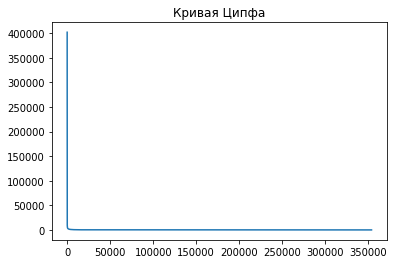

In [16]:
##
## 5 Постройте кривые Ципфа и Хипса
##
freqs = list(lemms_cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs, range(len(lemms_cnt)))
plt.title("Кривая Ципфа")
plt.show()

In [17]:
len(n_tokens)

35245140

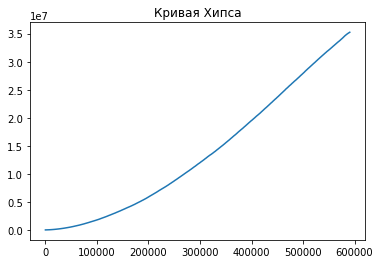

In [18]:
fig, ax = plt.subplots()
ax.plot(n_types, n_tokens)
plt.title("Кривая Хипса")
plt.show()


In [19]:
##
## 7 В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. 
## Используйте меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы 
## для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)
##
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [20]:
def process_text(pm2, text):
    lemms = []
    for word in text.split():
        word = word.lower()
        word = re.sub(r"[\d\.\,\-]", "", word)  # no digits
        if not word in mystopwords and not word == "":
            parse = pm2.parse(word)
            lemms.append( parse[0][2] )
    return lemms

In [21]:
tfidf_good = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_bad = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
matrix_good =  tfidf_good.fit_transform(resp_good)
matrix_bad  =  tfidf_bad.fit_transform(resp_bad)

In [22]:
from tqdm import tqdm_notebook 

In [23]:
words_good = {}
words_good_list = tfidf_good.get_feature_names()
words_good_list_flags = [True] * len(words_good_list)

for i in tqdm( range(len(matrix_good.indptr)-1)):
    cols = matrix_good.indices[ matrix_good.indptr[i]:matrix_good.indptr[i+1] ]
    values = matrix_good.data[ matrix_good.indptr[i]:matrix_good.indptr[i+1] ]
    for j in range(len(cols)):
        if words_good_list_flags[ cols[j] ]:
            words_good[ words_good_list[ cols[j] ] ] = values[j]
            words_good_list_flags[ cols[j] ] = False

100%|██████████| 1858530/1858530 [00:04<00:00, 438505.86it/s]


In [24]:
words_good_sorted = sorted( words_good.items(), key=lambda x: x[1], reverse = True )

In [25]:
words_good_sorted[:50]

[('досрочно', 1.0),
 ('закрывать', 1.0),
 ('вклад', 1.0),
 ('отпуск', 1.0),
 ('жена', 1.0),
 ('заказывать', 1.0),
 ('заранее', 1.0),
 ('забыть', 1.0),
 ('заказать', 1.0),
 ('сотрудник', 1.0),
 ('банка', 1.0),
 ('спб', 1.0),
 ('ленсовет', 1.0),
 ('наталья', 1.0),
 ('отказать', 1.0),
 ('сумма', 1.0),
 ('значительный', 1.0),
 ('работать', 1.0),
 ('быстро', 1.0),
 ('профессионально', 1.0),
 ('лишний', 1.0),
 ('жаль', 1.0),
 ('прикрыть', 1.0),
 ('приём', 1.0),
 ('офис', 1.0),
 ('озерко', 1.0),
 ('доступность', 1.0),
 ('заметить', 1.0),
 ('нести', 1.0),
 ('деньга', 1.0),
 ('брать', 1.0),
 ('кредит', 1.0),
 ('желать', 1.0),
 ('успех', 1.0),
 ('хотеть', 1.0),
 ('открыть', 1.0),
 ('год', 1.0),
 ('процент', 1.0),
 ('начисляться', 1.0),
 ('лесенка', 1.0),
 ('месяц', 1.0),
 ('общий', 1.0),
 ('объесть', 1.0),
 ('дополнительный', 1.0),
 ('взнос', 1.0),
 ('превышать', 1.0),
 ('первоначальный', 1.0),
 ('нужный', 1.0),
 ('возможность', 1.0),
 ('пополнение', 1.0)]

In [26]:
words_bad = {}
words_bad_list = tfidf_bad.get_feature_names()
words_bad_list_flags = [True] * len(words_bad_list)

for i in tqdm( range(len(matrix_bad.indptr)-1) ):
    cols = matrix_bad.indices[ matrix_bad.indptr[i]:matrix_bad.indptr[i+1] ]
    values = matrix_bad.data[ matrix_bad.indptr[i]:matrix_bad.indptr[i+1] ]
    for j in range(len(cols)):
        if words_bad_list_flags[ cols[j] ]:
            words_bad[ words_bad_list[ cols[j] ] ] = values[j]
            words_bad_list_flags[ cols[j] ] = False

100%|██████████| 7417372/7417372 [00:16<00:00, 445207.54it/s]


In [27]:
words_bad_sorted = sorted( words_bad.items(), key=lambda x: x[1], reverse = True )

words_bad_sorted[:50]

[('открытый', 1.0),
 ('вклад', 1.0),
 ('счёт', 1.0),
 ('плюс', 1.0),
 ('это', 1.0),
 ('зарплатный', 1.0),
 ('карта', 1.0),
 ('рубль', 1.0),
 ('сам', 1.0),
 ('себя', 1.0),
 ('сегодня', 1.0),
 ('прийти', 1.0),
 ('указанный', 1.0),
 ('отделение', 1.0),
 ('цель', 1.0),
 ('пополнить', 1.0),
 ('долларовый', 1.0),
 ('дать', 1.0),
 ('операционист', 1.0),
 ('паспорт', 1.0),
 ('окошко', 1.0),
 ('написать', 1.0),
 ('приготовить', 1.0),
 ('подтверждение', 1.0),
 ('чтоть', 1.0),
 ('подобный', 1.0),
 ('прошлый', 1.0),
 ('сказать', 1.0),
 ('нужно', 1.0),
 ('положить', 1.0),
 ('деньга', 1.0),
 ('весь', 1.0),
 ('взять', 1.0),
 ('делалакрутилавертеть', 1.0),
 ('вставить', 1.0),
 ('терминал', 1.0),
 ('ввести', 1.0),
 ('пин', 1.0),
 ('получить', 1.0),
 ('ответ', 1.0),
 ('чек', 1.0),
 ('доллар', 1.0),
 ('внести', 1.0),
 ('вопрос', 1.0),
 ('банка', 1.0),
 ('понимать', 1.0),
 ('кто', 1.0),
 ('сознательно', 1.0),
 ('проводить', 1.0),
 ('такой', 1.0)]

In [28]:
# посмотрим на ключевые биграммы
tfidf_bi_good = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_bi_bad = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
matrix_bi_good =  tfidf_bi_good.fit_transform(resp_bi_good)
matrix_bi_bad  =  tfidf_bi_bad.fit_transform(resp_bi_bad)

In [29]:
words_bi_good = {}
words_bi_good_list = tfidf_bi_good.get_feature_names()
words_bi_good_list_flags = [True] * len(words_bi_good_list)

for i in tqdm( range(len(matrix_bi_good.indptr)-1)):
    cols = matrix_bi_good.indices[ matrix_bi_good.indptr[i]:matrix_bi_good.indptr[i+1] ]
    values = matrix_bi_good.data[ matrix_bi_good.indptr[i]:matrix_bi_good.indptr[i+1] ]
    for j in range(len(cols)):
        if words_bi_good_list_flags[ cols[j] ]:
            words_bi_good[ words_bi_good_list[ cols[j] ] ] = values[j]
            words_bi_good_list_flags[ cols[j] ] = False
            
words_bi_good_sorted = sorted( words_bi_good.items(), key=lambda x: x[1], reverse = True )

100%|██████████| 14713/14713 [00:01<00:00, 10721.80it/s]


In [30]:
words_bi_good_sorted[:50]

[('маштакова анна', 0.6719516029156676),
 ('mastercard сделать', 0.5985088644142433),
 ('довольный команда', 0.5716501188317508),
 ('день корректно', 0.5416598387276468),
 ('корректно красиво', 0.5416598387276468),
 ('недоразумение проволочка', 0.5379632743916033),
 ('космонавт никакой', 0.5108987110064608),
 ('сидеть германия', 0.508662715405405),
 ('германия кредитка', 0.508662715405405),
 ('кредитка альфабанк', 0.508662715405405),
 ('райф банк', 0.507651171547205),
 ('филиал мег', 0.5031439083962906),
 ('мег профсоюзный', 0.5031439083962906),
 ('профсоюзный довольный', 0.5031439083962906),
 ('дельта нравиться', 0.5018543113392652),
 ('екатерина андрей', 0.4981345155746222),
 ('роман иван', 0.4976750123206486),
 ('банковский гарантия', 0.49545458580562785),
 ('тверская очередь', 0.4911942833949286),
 ('стоялый обслуживание', 0.4911942833949286),
 ('замена залог', 0.47980639291224264),
 ('ростовенадон вежливый', 0.4776031480153513),
 ('автомобиль никакой', 0.47310220704887296),
 ('зам

In [31]:
words_bi_bad = {}
words_bi_bad_list = tfidf_bi_bad.get_feature_names()
words_bi_bad_list_flags = [True] * len(words_bi_bad_list)

for i in tqdm( range(len(matrix_bi_bad.indptr)-1) ):
    cols = matrix_bi_bad.indices[ matrix_bi_bad.indptr[i]:matrix_bi_bad.indptr[i+1] ]
    values = matrix_bi_bad.data[ matrix_bi_bad.indptr[i]:matrix_bi_bad.indptr[i+1] ]
    for j in range(len(cols)):
        if words_bi_bad_list_flags[ cols[j] ]:
            words_bi_bad[ words_bi_bad_list[ cols[j] ] ] = values[j]
            words_bi_bad_list_flags[ cols[j] ] = False
            
words_bi_bad_sorted = sorted( words_bi_bad.items(), key=lambda x: x[1], reverse = True )

100%|██████████| 47387/47387 [00:04<00:00, 11042.49it/s]


In [32]:
words_bi_bad_sorted[:50]

[('ms ms', 0.8025402631688167),
 ('ив марьяна', 0.6524476042717388),
 ('банка рублёв', 0.6364950215877374),
 ('промурыжить выдача', 0.5886755848328097),
 ('анкин сергей', 0.5834934637521875),
 ('овердрафт rur', 0.5832329840035296),
 ('плат овердрафт', 0.5675043236366187),
 ('отделение велозаводский', 0.5588046823175169),
 ('волокита именно', 0.5502973625330906),
 ('оплата moscow', 0.5497449902979568),
 ('гудок гудок', 0.5413707004283994),
 ('сбербанк управление', 0.5296923709127136),
 ('кредит снежный', 0.5233742629873314),
 ('снежный прождать', 0.5233742629873314),
 ('архивный выписка', 0.5221268247389663),
 ('mosienko artem', 0.5210041470932594),
 ('отступное процент', 0.5181634413785379),
 ('красногорский филиал', 0.5165482644896662),
 ('oplata kartoj', 0.5137615268570089),
 ('sms кемерово', 0.5132389647755378),
 ('попасть снять', 0.5109509864199082),
 ('служба назначение', 0.5102693978875839),
 ('чвой си', 0.5100643482073288),
 ('ребята линия', 0.5085937835105773),
 ('hsbc uk', 0.5

In [33]:
# Попробуем сравнить результат с BigramAssocMeasures и BigramCollocationFinder
#%%time 
import nltk
from nltk.collocations import *
N_best = 100

bigram_measures_good = nltk.collocations.BigramAssocMeasures() # класс для мер ассоциации биграм
finder_good = BigramCollocationFinder.from_words(resp_good) # класс для хранения и извлечения биграм
finder_good.apply_freq_filter(1) # избавимся от биграм, которые встречаются реже трех раз
raw_freq_ranking_good = [' '.join(i) for i in finder_good.nbest(bigram_measures_good.raw_freq, N_best)] # выбираем топ-10 биграм по частоте 
tscore_ranking_good = [' '.join(i) for i in finder_good.nbest(bigram_measures_good.student_t, N_best)] # выбираем топ-100 биграм по каждой мере 
pmi_ranking_good =  [' '.join(i) for i in finder_good.nbest(bigram_measures_good.pmi, N_best)]
llr_ranking_good = [' '. join(i) for i in finder_good.nbest(bigram_measures_good.likelihood_ratio, N_best)]
chi2_ranking_good =  [' '.join(i) for i in finder_good.nbest(bigram_measures_good.chi_sq, N_best)]

In [34]:
rankings_good = pd.DataFrame({ 'chi2': chi2_ranking_good, 'llr':llr_ranking_good, 't-score' : tscore_ranking_good, 'pmi': pmi_ranking_good, 'raw_freq':raw_freq_ranking_good})
rankings_good = rankings_good[['raw_freq', 'pmi', 't-score', 'chi2', 'llr']]
rankings_good.head(10)

,raw_freq,pmi,t-score,chi2,llr
0,кредитный карта,"""acropolis rentacar""",кредитный карта,"""acropolis rentacar""",кредитный карта
1,сотрудник банка,"""all airlines""",сотрудник банка,"""all airlines""",следующий день
2,другой банка,"""american express"")",другой банка,"""american express"")",процентный ставка
3,клиент банка,"""caisse d'epargne""",следующий день,"""caisse d'epargne""",являться клиент
4,следующий день,"""call your",являться клиент,"""call your",денежный средство
5,являться клиент,"""comfort idea",клиент банка,"""comfort idea",хотеть выразить
6,отделение банка,"""d secure""",дебетовый карта,"""d secure""",сотрудник банка
7,дебетовый карта,"""diners club""",отделение банка,"""diners club""",выразить благодарность
8,процентный ставка,"""global blue""",процентный ставка,"""global blue""",другой банка
9,открыть вклад,"""id _____________""",открыть вклад,"""id _____________""",дебетовый карта


In [35]:
N_best = 100

bigram_measures_bad = nltk.collocations.BigramAssocMeasures() # класс для мер ассоциации биграм
finder_bad = BigramCollocationFinder.from_words(resp_bad) # класс для хранения и извлечения биграм
finder_bad.apply_freq_filter(3) # избавимся от биграм, которые встречаются реже трех раз
raw_freq_ranking_bad = [' '.join(i) for i in finder_bad.nbest(bigram_measures_bad.raw_freq, N_best)] # выбираем топ-10 биграм по частоте 
tscore_ranking_bad = [' '.join(i) for i in finder_bad.nbest(bigram_measures_bad.student_t, N_best)] # выбираем топ-100 биграм по каждой мере 
pmi_ranking_bad =  [' '.join(i) for i in finder_bad.nbest(bigram_measures_bad.pmi, N_best)]
llr_ranking_bad = [' '. join(i) for i in finder_bad.nbest(bigram_measures_bad.likelihood_ratio, N_best)]
chi2_ranking_bad =  [' '.join(i) for i in finder_bad.nbest(bigram_measures_bad.chi_sq, N_best)]

In [36]:
rankings_bad = pd.DataFrame({ 'chi2': chi2_ranking_bad, 'llr':llr_ranking_bad, 't-score' : tscore_ranking_bad, 'pmi': pmi_ranking_bad, 'raw_freq':raw_freq_ranking_bad})
rankings_bad = rankings_bad[['raw_freq', 'pmi', 't-score', 'chi2', 'llr']]
rankings_bad.head(10)

,raw_freq,pmi,t-score,chi2,llr
0,сотрудник банка,"""golden times""",сотрудник банка,"""golden times""",денежный средство
1,отделение банка,caps lock,денежный средство,(invalid img),горячий линия
2,кредитный карта,computer ksa,написать заявление,british airways,сей пора
3,денежный средство,déjà vu,кредитный карта,caps lock,написать заявление
4,написать заявление,israeli shekel,отделение банка,computer ksa,сотрудник банка
5,горячий линия,izmenenie ostatka:,горячий линия,déjà vu,служба поддержка
6,рабочий день,larisag nepomnyashchikh,рабочий день,golden times,кредитный карта
7,следующий день,valid thru,следующий день,hotels com,досрочный погашение
8,сей пора,анри барбюс,сей пора,israeli shekel,рабочий день
9,служба поддержка,блокадный ленинград,служба поддержка,izmenenie ostatka:,следующий день


In [37]:
# так гораздо лучше, хотя косяков много - надо бы почистить лучше данные

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [38]:
import gensim
from gensim import corpora
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [39]:
dictionary = corpora.Dictionary(resp_all_text[:lenresp])
corpus = [dictionary.doc2bow(text) for text in resp_all_text]

In [40]:
#[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [42]:
pprint(lda_model.print_topics(5))

[(5,
  '0.031*"банка" + 0.023*"мой" + 0.020*"банк" + 0.017*"сотрудник" + '
  '0.017*"ваш" + 0.015*"клиент" + 0.015*"письмо" + 0.013*"дать" + 0.012*"год" '
  '+ 0.010*"который"'),
 (3,
  '0.069*"документ" + 0.030*"–" + 0.025*"анкета" + 0.022*"мы" + 0.019*"наш" + '
  '0.018*"заполнить" + 0.017*"паспорт" + 0.015*"справка" + 0.012*"копия" + '
  '0.011*"получение"'),
 (4,
  '0.043*"банка" + 0.026*"банк" + 0.020*"вклад" + 0.020*"клиент" + '
  '0.016*"обслуживание" + 0.010*"открыть" + 0.009*"хороший" + 0.009*"процент" '
  '+ 0.008*"сайт" + 0.008*"быстро"'),
 (1,
  '0.028*"деньга" + 0.027*"день" + 0.019*"банка" + 0.018*"отделение" + '
  '0.016*"мой" + 0.015*"сказать" + 0.013*"позвонить" + 0.012*"заявление" + '
  '0.011*"банк" + 0.011*"получить"'),
 (2,
  '0.014*"работать" + 0.011*"человек" + 0.011*"один" + 0.011*"очередь" + '
  '0.010*"минута" + 0.010*"такой" + 0.010*"просто" + 0.009*"время" + '
  '0.009*"весь" + 0.008*"клиент"')]


In [43]:
lda_model.log_perplexity(corpus)

-7.85026074537226

In [44]:
lda_model.get_document_topics(corpus[0])

[(0, 0.058299266),
 (1, 0.108884886),
 (2, 0.12977049),
 (3, 0.04226758),
 (4, 0.032765687),
 (5, 0.61409026),
 (6, 0.01392176)]

In [45]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')


C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [46]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.014302 -0.006093       1        1  30.357382
2     -0.098802 -0.360564       2        1  22.280373
4     -0.332633 -0.126378       3        1  12.746881
6     -0.278202  0.253707       4        1  11.892330
5      0.251422 -0.250121       5        1   9.302924
0      0.318609  0.065356       6        1   8.934264
3      0.153908  0.424094       7        1   4.485841, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
132   Default  287858.000000         карта  287858.000000  30.0000  30.0000
258   Default  179618.000000        кредит  179618.000000  29.0000  29.0000
3     Default  328989.000000         банка  328989.000000  28.0000  28.0000
200   Default  158955.000000          счёт  158955.000000  27.0000  27.0000
25    Default   64354.000000      документ   64354.000000  26.0000  26.0000
245   Default  174557.000000          день  174557.000000  25.0000  25.0000
208   Default  193619.000000        деньга  193619.000000  24.0000  24.0000
54    Default  149732.000000           мой  149732.000000  23.0000  23.0000
47    Default   95385.000000     кредитный   95385.000000  22.0000  22.0000
199   Default   91773.000000         сумма   91773.000000  21.0000  21.0000
2     Default  234022.000000          банк  234022.000000  20.0000  20.0000
193   Default   78086.000000         рубль   78086.000000  19.0000  19.0000
44    Default  119427.000000        клиент  119427.000000  18.0000  18.0000
186   Default   58722.000000        платёж   58722.000000  17.0000  17.0000
216   Default   82378.000000         месяц   82378.000000  16.0000  16.0000
854   Default   52931.000000         вклад   52931.000000  15.0000  15.0000
144   Default  149555.000000     отделение  149555.000000  14.0000  14.0000
777   Default   66325.000000      работать   66325.000000  13.0000  13.0000
278   Default   82175.000000     позвонить   82175.000000  12.0000  12.0000
24    Default   64167.000000       договор   64167.000000  11.0000  11.0000
17    Default  128238.000000           год  128238.000000  10.0000  10.0000
21    Default   85361.000000          дать   85361.000000   9.0000   9.0000
1217  Default   27805.000000             –   27805.000000   8.0000   8.0000
329   Default   52508.000000       процент   52508.000000   7.0000   7.0000
7     Default   48345.000000           ваш   48345.000000   6.0000   6.0000
217   Default   52801.000000  обслуживание   52801.000000   5.0000   5.0000
36    Default   80625.000000     заявление   80625.000000   4.0000   4.0000
1187  Default   51608.000000       очередь   51608.000000   3.0000   3.0000
752   Default   81255.000000      банкомат   81255.000000   2.0000   2.0000
442   Default  103889.000000     сотрудник  103889.000000   1.0000   1.0000
...       ...            ...           ...            ...      ...      ...
3900   Topic7    2023.917847         книга    2025.231689   3.1036  -6.1332
6131   Topic7    1860.710815      солидный    1862.027954   3.1035  -6.2173
3385   Topic7    1791.938599     налоговый    1793.252075   3.1035  -6.2550
2045   Topic7    1796.903931      объявить    1798.221924   3.1035  -6.2522
8686   Topic7    1754.179199   предприятие    1755.495483   3.1035  -6.2763
2591   Topic7    1739.183105        притом    1740.499146   3.1035  -6.2849
5245   Topic7    1676.159180   иностранный    1677.476807   3.1035  -6.3218
1666   Topic7   20221.558594            мы   20582.287109   3.0866  -3.8315
1347   Topic7   11343.546875         копия   11872.197266   3.0587  -4.4096
256    Topic7    9258.620117      компания   11091.563477   2.9236  -4.6127
403    Topic7   13970.112305       справка   17873.556641   2.8578  -4.2014
1345   Topic7    8430.613281         доход   10199.861328   2.9137  -4.7064
523    Topic7   17326.521484           наш   24178.

In [47]:
# примеры тем
# 1 - претензии, заявления, звоновый центр
# 2 - офисы
# 3 - вклады
# 4 - карты
# 5 - проблемы, заявления, суды
# 6 - кредиты
# 7 - недвижимость


In [48]:
##
## Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). 
## Можете ли вы их прокомментировать / объяснить?
##

In [49]:
# вот расклад тем по банкам
from collections import defaultdict

In [50]:
banks_topics = defaultdict(lambda: defaultdict(int))
banks_ntopics = defaultdict(lambda: defaultdict(int))
for i in range(100):
    topics = lda_model.get_document_topics( corpus[i] )
    bank_name = responses[i]['bank_name']
    if bank_name == 'Бинбанк':
        print (responses[i]['text'])
        print (topics)
    ntopics = defaultdict(int)
    for topic in topics:
        banks_topics[bank_name][topic[0]]+=topic[1]
        banks_ntopics[bank_name][topic[0]]+=1
    
for bank_name in banks_topics.keys():
    for topic in banks_topics[bank_name].keys():
        banks_topics[bank_name][topic] = banks_topics[bank_name][topic] / banks_ntopics[bank_name][topic]



Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью  хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,  и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мне серье

In [51]:
# keys = sorted(banks_topics['Бинбанк'].keys(), key=lambda x: banks_topics['Бинбанк'][x], reverse = True)
# keys

In [52]:
banks_topics['Бинбанк']


defaultdict(int,
            {0: 0.05148749724030495,
             1: 0.24843552261590957,
             2: 0.14917904436588286,
             3: 0.08955032099038363,
             4: 0.14199581891298294,
             5: 0.19970800168812275,
             6: 0.11964379716664553})

In [53]:
# for i in banks_topics:
#     #banks_topics[i].sort(key=lambda x: x[1], reverse = True)
#     keys = sorted(banks_topics[i].keys(), key=lambda x: banks_topics[i][x], reverse = True)
    
#     banks_topics[i] = sorted(banks_topics[i].keys(),reverse = True)
#     #rint (type(banks_topics[i]))

In [54]:
# список наиболее обсуждаемых тем для каждого банка <название банка> (общее кол-во отзывов): <номера тем согласно vis выше>
# если сюда добавить еще кол-во сообщений по каждой теме (лень), то можно делать интересные выводы 
# и погружаться в конкретные болевые проблемы того или иного банка
for i in banks_topics:
    ss = ""
    keys = sorted(banks_topics[i].keys(), key=lambda x: banks_topics[i][x], reverse = True)
    for topic in keys:
        if banks_topics[i][topic] > 0.2:
            ss += f'{topic+1}, '
        else:
            break
    print (f'{i}({banks_cnt[i]}): {ss}')
    

Бинбанк(1646): 2, 
Сбербанк России(26327): 2, 7, 
ОТП Банк(3237): 2, 1, 
Гагаринский(19): 2, 
Тинькофф Банк(5387): 5, 6, 
Восточный Экспресс Банк(3138): 6, 
ВТБ 24(8185): 2, 1, 
Альфа-Банк(10224): 2, 
БИНБАНК кредитные карты(1464): 2, 7, 
МТС Банк(1870): 3, 
Совкомбанк(919): 3, 1, 
Россельхозбанк(532): 3, 2, 
Московский Кредитный Банк(2944): 1, 
МДМ Банк(776): 3, 
Хоум Кредит Банк(7549): 2, 
Бенифит-Банк(115): 5, 2, 
Уральский Банк Реконструкции и Развития(532): 2, 3, 
Русский Стандарт(7943): 6, 3, 
Лето Банк(501): 2, 1, 
Петрокоммерц(339): 7, 2, 3, 
Русфинанс Банк(723): 2, 
Киви Банк(1741): 4, 
Ханты-Мансийский банк Открытие(2158): 7, 
Русславбанк(715): 2, 5, 7, 
Татфондбанк(159): 1, 3, 2, 
МАСТ-Банк(208): 2, 
Национальный Банк «Траст»(4607): 3, 2, 
Военно-Промышленный Банк(149): 2, 
АктивКапитал Банк(75): 5, 
Связной Банк(3775): 2, 
Платежный Центр(13): 2, 7, 
Московский Индустриальный Банк(271): 7, 3, 
Финансовый Стандарт(125): 5, 3, 
Ренессанс Кредит(3849): 2, 1, 
Югра(451): 3, 2, 

In [55]:
# Похоже, что у Бинбанка проблемы с офисами (или они прекрасны, если все отзывы положительрные)
# По Сберу часто обсуждают те же офисы и ипотеку 
# и так далее 

In [56]:
banks_topics

defaultdict(<function __main__.<lambda>()>,
            {'Бинбанк': defaultdict(int,
                         {0: 0.05148749724030495,
                          1: 0.24843552261590957,
                          2: 0.14917904436588286,
                          3: 0.08955032099038363,
                          4: 0.14199581891298294,
                          5: 0.19970800168812275,
                          6: 0.11964379716664553}),
             'Сбербанк России': defaultdict(int,
                         {0: 0.06615340212980907,
                          1: 0.3673678507407506,
                          2: 0.17095068941513697,
                          3: 0.04436863539740443,
                          4: 0.09889961468676726,
                          5: 0.05144760970558439,
                          6: 0.20623505140344303}),
             'ОТП Банк': defaultdict(int,
                         {0: 0.2446595405538877,
                          1: 0.37332280973593396,
                      

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *

In [58]:
X_train_good, X_test_good = train_test_split(resp_bi_good)
X_train_bad, X_test_bad = train_test_split(resp_bi_bad)

X_train = X_train_good + X_train_bad
X_test = X_test_good + X_test_bad
y_train = [5 for i in range(len(X_train_good))] + [1 for i in range(len(X_train_bad))]
y_test = [5 for i in range(len(X_test_good))] + [1 for i in range(len(X_test_bad))]

In [59]:
vect = CountVectorizer()
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

clf = RandomForestClassifier( max_depth = 15 )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [60]:
def print_result(y_test, Y_test):
    print("Precision: {0:6.2f}".format(precision_score(y_test, Y_test, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(y_test, Y_test, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(y_test, Y_test, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, Y_test)))
    print(classification_report(y_test, Y_test))
    labels = clf.classes_

    sns.heatmap(data=confusion_matrix(y_test, Y_test), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix")
    plt.show()

Precision:   0.89
Recall:   0.55
F1-measure:   0.53
Accuracy:   0.79
              precision    recall  f1-score   support

           1       0.78      1.00      0.88     11847
           5       0.99      0.10      0.18      3679

   micro avg       0.79      0.79      0.79     15526
   macro avg       0.89      0.55      0.53     15526
weighted avg       0.83      0.79      0.71     15526



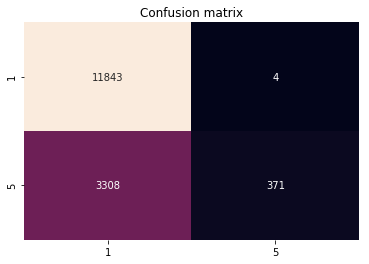

In [61]:
print_result(y_test, Y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.89
Recall:   0.56
F1-measure:   0.55
Accuracy:   0.79
              precision    recall  f1-score   support

           1       0.79      1.00      0.88     11847
           5       0.99      0.13      0.23      3679

   micro avg       0.79      0.79      0.79     15526
   macro avg       0.89      0.56      0.55     15526
weighted avg       0.83      0.79      0.73     15526



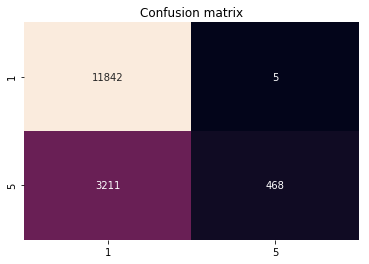

In [62]:
# пробуем tfidf
vect = TfidfVectorizer()
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

clf = RandomForestClassifier( max_depth = 15 )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.90
Recall:   0.73
F1-measure:   0.77
Accuracy:   0.87
              precision    recall  f1-score   support

           1       0.86      0.99      0.92     11847
           5       0.95      0.46      0.62      3679

   micro avg       0.87      0.87      0.87     15526
   macro avg       0.90      0.73      0.77     15526
weighted avg       0.88      0.87      0.85     15526



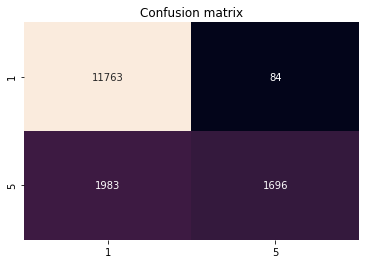

In [63]:
# пробуем разные параметры, в итоге лучше всех "1 слово" и forest с параметрами по умолчанию
vect = CountVectorizer(ngram_range=(3, 6), analyzer='char')
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

clf = RandomForestClassifier(  )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.90
Recall:   0.74
F1-measure:   0.78
Accuracy:   0.87
              precision    recall  f1-score   support

           1       0.86      0.99      0.92     11847
           5       0.94      0.49      0.64      3679

   micro avg       0.87      0.87      0.87     15526
   macro avg       0.90      0.74      0.78     15526
weighted avg       0.88      0.87      0.85     15526



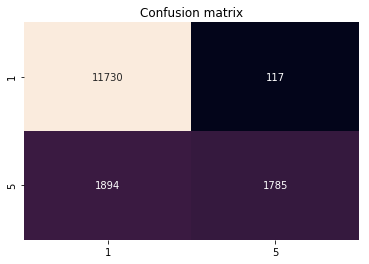

In [64]:
# пробуем разные параметры
vect = TfidfVectorizer( ngram_range=(1, 1), analyzer='word' )
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

clf = RandomForestClassifier(  )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision:   0.96
Recall:   0.93
F1-measure:   0.95
Accuracy:   0.96
              precision    recall  f1-score   support

           1       0.96      0.99      0.98     11847
           5       0.97      0.87      0.92      3679

   micro avg       0.96      0.96      0.96     15526
   macro avg       0.96      0.93      0.95     15526
weighted avg       0.96      0.96      0.96     15526



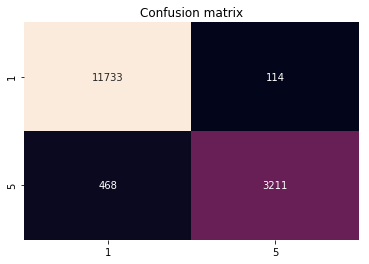

In [66]:
# пробуем разные параметры, логистическая регрессия
vect = TfidfVectorizer( ngram_range=(1, 1), analyzer='word' )
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

clf = LogisticRegression(  )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

Precision:   0.84
Recall:   0.69
F1-measure:   0.72
Accuracy:   0.84
              precision    recall  f1-score   support

           1       0.84      0.98      0.90     11847
           5       0.85      0.40      0.54      3679

   micro avg       0.84      0.84      0.84     15526
   macro avg       0.84      0.69      0.72     15526
weighted avg       0.84      0.84      0.82     15526



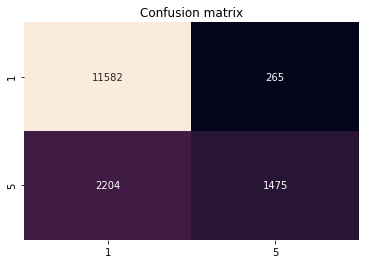

In [67]:
# пробуем разные параметры, MultinomialNB
vect = TfidfVectorizer( ngram_range=(1, 1), analyzer='word' )
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

clf = KNeighborsClassifier( n_neighbors=3 )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

In [68]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.90
Recall:   0.74
F1-measure:   0.78
Accuracy:   0.87
              precision    recall  f1-score   support

           1       0.86      0.99      0.92     11847
           5       0.93      0.49      0.64      3679

   micro avg       0.87      0.87      0.87     15526
   macro avg       0.90      0.74      0.78     15526
weighted avg       0.88      0.87      0.86     15526



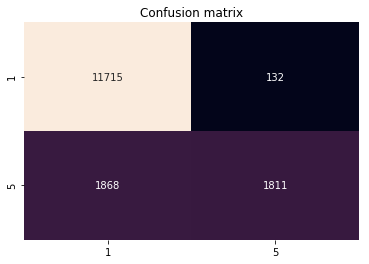

In [69]:
# пробуем tfidftransformer
vect = TfidfVectorizer( ngram_range=(1, 1), analyzer='word' )
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

clf = RandomForestClassifier(  )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

In [70]:
# разницы существенной нет между tfidf vectorizer и transformer

In [71]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.86
Recall:   0.67
F1-measure:   0.70
Accuracy:   0.84
              precision    recall  f1-score   support

           1       0.83      0.99      0.90     11847
           5       0.89      0.35      0.50      3679

   micro avg       0.84      0.84      0.84     15526
   macro avg       0.86      0.67      0.70     15526
weighted avg       0.85      0.84      0.81     15526



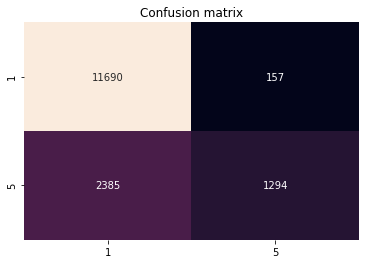

In [72]:
# пробуем tfidftransformer
vect = TfidfVectorizer( ngram_range=(1, 1), analyzer='word' )
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

svd = TruncatedSVD( 700 )
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
vect_train = lsa.fit_transform(vect_train)
vect_test = lsa.transform(vect_test)

clf = RandomForestClassifier(  )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

In [73]:
# при сокращении кол-ва фич до 700 через SVD качество существенно падает

In [74]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.58
Recall:   0.50
F1-measure:   0.44
Accuracy:   0.76
              precision    recall  f1-score   support

           1       0.76      1.00      0.86     11847
           5       0.39      0.01      0.01      3679

   micro avg       0.76      0.76      0.76     15526
   macro avg       0.58      0.50      0.44     15526
weighted avg       0.68      0.76      0.66     15526



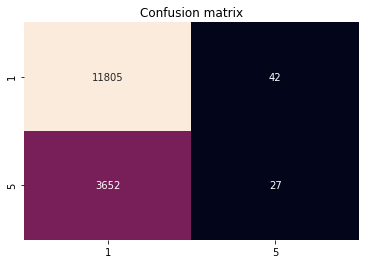

In [75]:
# пробуем tfidftransformer
vect = TfidfVectorizer( ngram_range=(1, 1), analyzer='word' )
vect_train = vect.fit_transform(X_train)
vect_test = vect.transform(X_test)

lda = LatentDirichletAllocation(n_components=700, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
vect_train = lda.fit_transform(vect_train)
vect_test = lda.transform(vect_test)

clf = RandomForestClassifier(  )
clf.fit(vect_train, y_train)

Y_test = clf.predict(vect_test)

print_result(y_test, Y_test)

In [ ]:
# итого лучшим получилась связка tfidf + логистическая регрессия

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier

# # !!! На каждом этапе Pipeline нужно указать свои параметры
# # 1-ый вариант: tf-idf + LSI
# # 2-ой вариант: LDA

# # clf = Pipeline([
# #     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
# #     ('clf', RandomForestClassifier()),
# # ])



# clf = Pipeline([ 
#     ('vect', CountVectorizer()), 
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD()), 
#     ('clf', RandomForestClassifier())
# ])
